<a href="https://colab.research.google.com/github/adhammkhaled/Pattern-Recognition-Labs/blob/main/Image%20Classification/Husky_vs_Wolf_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Husky🐶 Vs Wolf🐺

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Data Loading

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import default_loader
from sklearn.model_selection import train_test_split,GridSearchCV
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import itertools

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # Normalize to [-1,1]
])
# dataset = datasets.ImageFolder(root="train", transform=transform)

# colab
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/Husky_Wolf_Dataset/train", transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 97
    Root location: /content/drive/MyDrive/Husky_Wolf_Dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## Data Splitting

In [ ]:
# Get images and labels
image_paths = dataset.imgs
#print(image_paths)
# Unpack using zip(*)
images, labels = zip(*image_paths)
# Split 80% training, 20% validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = default_loader(self.image_paths[idx])  # Load image

        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


## Data Preprocessing

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),       # Resize to fixed dimensions
    transforms.RandomHorizontalFlip(),   # Flip images randomly
    transforms.RandomRotation(15),       # Rotate images slightly
    transforms.RandomCrop(128, padding=10),  # Crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    transforms.GaussianBlur(kernel_size=(3, 3)),  # Reduce noise
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1,1]
])

# Create PyTorch datasets
train_dataset = CustomDataset(train_imgs, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_imgs, val_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")


Total images: 97
Training images: 77
Validation images: 20


## Visualize Sample Images

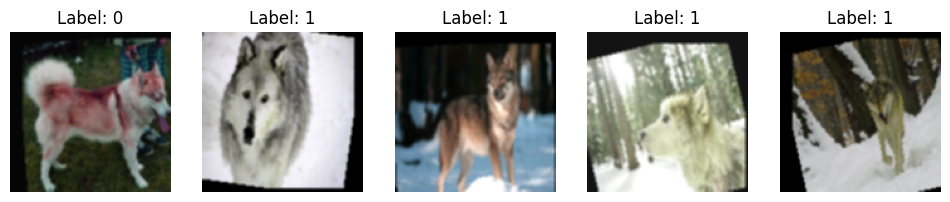

In [ ]:
# Get a batch from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Convert images to NumPy for visualization
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    img = np.transpose(images[i].numpy(), (1, 2, 0))  # Convert to HWC format
    img = (img * 0.5) + 0.5  # Unnormalize to [0,1]

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')
plt.show()


## Check the class names

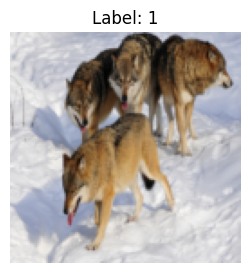

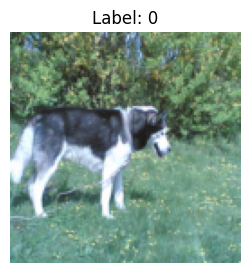

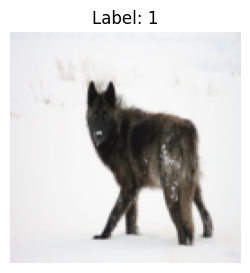

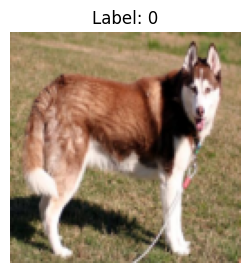

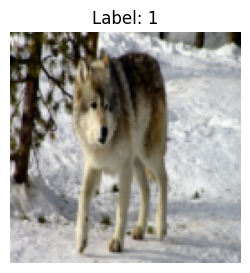

In [ ]:
# Define the denormalization transform
def denormalize(image):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Shape (C, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return image * std + mean  # Reverse the normalization

# Get first 5 samples and display
for i in range(5):
    image, label = val_loader.dataset[i]  # Get image and label

    if isinstance(image, torch.Tensor):
        image = denormalize(image)  # Apply denormalization
        image = torch.clamp(image, 0, 1)  # Ensure values are in [0,1]
        image = transforms.ToPILImage()(image)  # Convert to PIL image

    # Display the image
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Label: {label}")
    plt.show()

It's clear that 0 = Husky and Wolf = 1

# 1) Logistic Regression

## Convert Dataset to NumPy Arrays

In [ ]:
X_train, y_train = [], []
X_val, y_val = [], []

for image, label in train_loader.dataset:
    X_train.append(image.view(-1).numpy())  # Flatten image
    y_train.append(label)

for image, label in val_loader.dataset:
    X_val.append(image.view(-1).numpy())  # Flatten image
    y_val.append(label)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

## Train Logistic Regression

In [ ]:
log_reg = LogisticRegression()

# Define hyperparameters grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization
    'solver': ['liblinear', 'saga']  # Solver selection (for L1/L2)
}

# Perform GridSearchCV (cross-validation happens within training set)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Training with cross-validation

# Evaluate on the held-out validation set
val_accuracy = grid_search.best_estimator_.score(X_val, y_val)

#log_reg.fit(X_train, y_train)

## Evaluation

In [ ]:
# Evaluate on the held-out validation set
val_accuracy = grid_search.best_estimator_.score(X_val, y_val)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Val Accuracy:", grid_search.best_score_)
print("Validation Set Accuracy:", val_accuracy)

# accuracy = log_reg.score(X_val, y_val) * 100
# print(f"Validation Accuracy: {accuracy:.2f}%")

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Val Accuracy: 0.9
Validation Set Accuracy: 0.9


In [ ]:
# Define class mapping
class_mapping = {0: "Husky", 1: "Wolf"}

# Extract validation data
X_val, y_val = [], []
for images, labels in val_loader:
    X_val.append(images.view(images.shape[0], -1))  # Flatten images
    y_val.append(labels)

X_val = torch.cat(X_val).numpy()
y_val = torch.cat(y_val).numpy()

# Predict using Logistic Regression
y_pred = grid_search.best_estimator_.predict(X_val)

# Function to display images with predictions
def show_images(images, labels, predictions, num_rows=5, num_cols=4):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    axes = axes.flatten()

    for i in range(num_rows * num_cols):
        img = (X_val[i].reshape(3, 128, 128).transpose(1, 2, 0) +1)/2 # Adjusted from the data of RGB images
        ax = axes[i]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {class_mapping[labels[i]]}\nPred: {class_mapping[predictions[i]]}")

    plt.tight_layout()
    plt.show()

# Show images
show_images(X_val, y_val, y_pred)

# 2) CNN Model

## Define CNN Model

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv Layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),  # Flattened input to FC
            nn.ReLU(),
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(256, num_classes)  # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x


## Chossing the error and the optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2
model = CNNClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Train and evaluate

In [ ]:
def train_and_evaluate(params, train_loader, val_loader, num_classes, device):
    model = CNNClassifier(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    num_epochs = params['epochs']
    best_acc = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {acc:.2f}%")

        # Save best accuracy
        if acc > best_acc:
            best_acc = acc
            best_model = model.state_dict()

    return best_acc, best_model


## Make hyperparameters tuning

In [ ]:
import itertools
# Define hyperparameter grid
param_grid = {
    'lr': [0.001, 0.0005],
    'epochs': [10, 15],
    'batch_size': [32, 64]
}

best_acc = 0
best_params = None
best_model_state = None

for params in itertools.product(*param_grid.values()):
    params_dict = dict(zip(param_grid.keys(), params))

    train_loader = DataLoader(train_dataset, batch_size=params_dict['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params_dict['batch_size'], shuffle=False)

    acc, model_state = train_and_evaluate(params_dict, train_loader, val_loader, num_classes=2, device=device)
    print(f"Params: {params_dict}, Accuracy: {acc:.2f}%")

    if acc > best_acc:
        best_acc = acc
        best_params = params_dict
        best_model_state = model_state


# Save the best model
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
torch.save(best_model_state, "best_cnn_model.pth")
print(f"Best Params: {best_params}, Best Accuracy: {best_acc:.2f}%")

Epoch [1/10], Loss: 0.8880, Val Accuracy: 55.00%
Epoch [2/10], Loss: 0.7290, Val Accuracy: 65.00%
Epoch [3/10], Loss: 0.5266, Val Accuracy: 85.00%
Epoch [4/10], Loss: 0.3553, Val Accuracy: 90.00%
Epoch [5/10], Loss: 0.3749, Val Accuracy: 90.00%
Epoch [6/10], Loss: 0.3139, Val Accuracy: 85.00%
Epoch [7/10], Loss: 0.3626, Val Accuracy: 100.00%
Epoch [8/10], Loss: 0.4028, Val Accuracy: 100.00%
Epoch [9/10], Loss: 0.2054, Val Accuracy: 90.00%
Epoch [10/10], Loss: 0.2666, Val Accuracy: 95.00%
Params: {'lr': 0.001, 'epochs': 10, 'batch_size': 32}, Accuracy: 100.00%
Epoch [1/10], Loss: 0.6438, Val Accuracy: 50.00%
Epoch [2/10], Loss: 1.3819, Val Accuracy: 50.00%
Epoch [3/10], Loss: 0.9105, Val Accuracy: 65.00%
Epoch [4/10], Loss: 0.4686, Val Accuracy: 85.00%
Epoch [5/10], Loss: 0.4102, Val Accuracy: 100.00%
Epoch [6/10], Loss: 0.2924, Val Accuracy: 100.00%
Epoch [7/10], Loss: 0.1714, Val Accuracy: 95.00%
Epoch [8/10], Loss: 0.2606, Val Accuracy: 95.00%
Epoch [9/10], Loss: 0.2236, Val Accuracy

## Evaluation

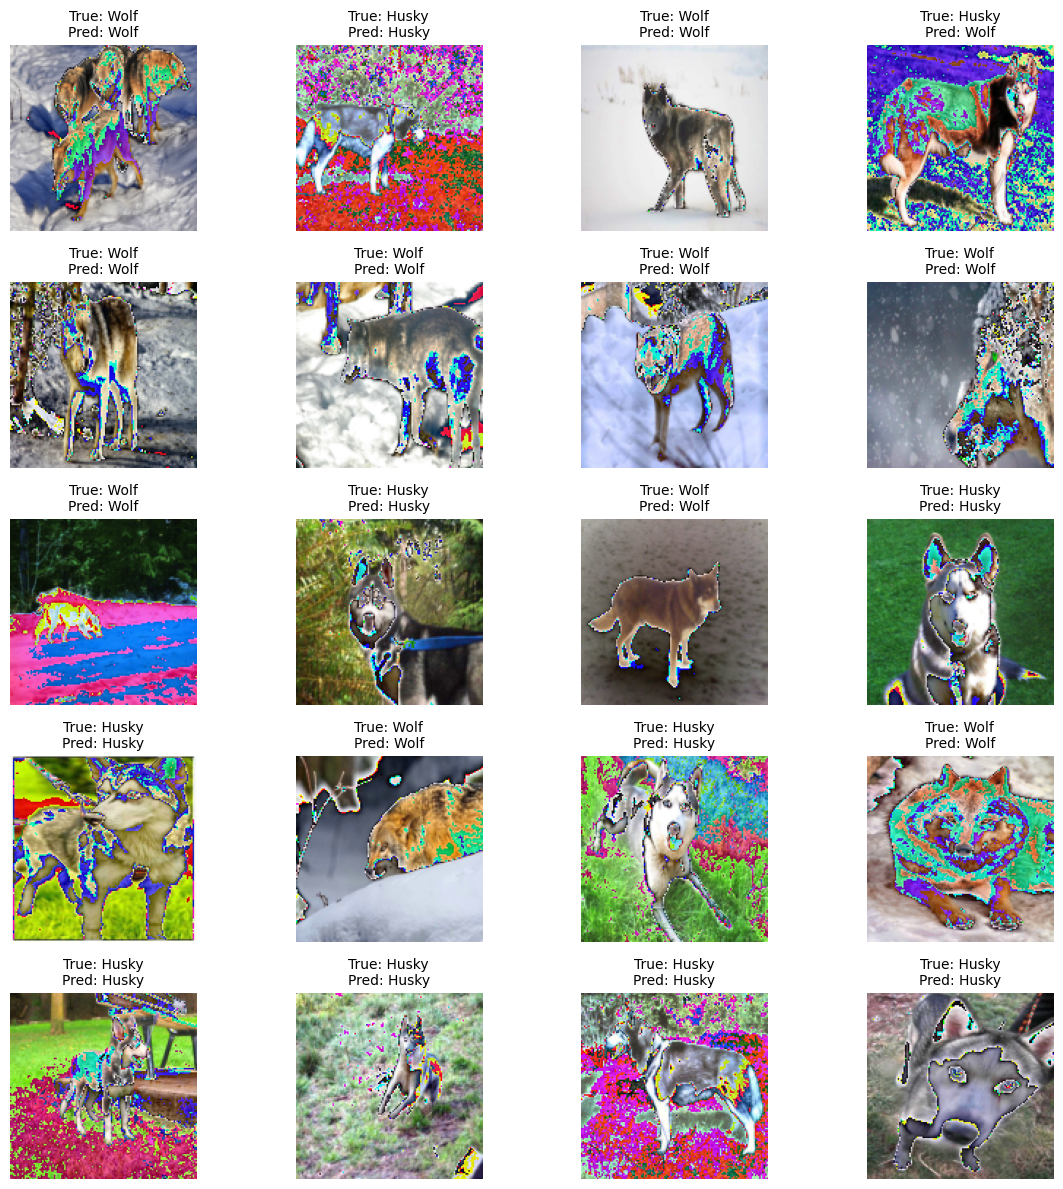

Validation Accuracy: 95.00%


In [ ]:
model = CNNClassifier(num_classes=2).to(device)
model.load_state_dict(torch.load("best_cnn_model.pth", weights_only=True))
model.eval()  # Set to evaluation mode
correct = 0
total = 0

# Disable gradient calculation
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Convert images to CPU for visualization
        images_cpu = images.cpu()
        labels_cpu = labels.cpu()
        predicted_cpu = predicted.cpu()

        # Define the grid size
        rows, cols = 5, 4
        fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

        for i in range(rows * cols):
            if i >= len(images_cpu):  # Avoid errors if we have fewer than 20 images (They are 20 but if dataset changes.)
                break

            img = transforms.ToPILImage()(images_cpu[i])  # Convert tensor to image
            ax = axes[i // cols, i % cols]  # Get the subplot position
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"True: {class_mapping[labels_cpu[i].item()]}\nPred: {class_mapping[predicted_cpu[i].item()]}", fontsize=10)

        plt.tight_layout()
        plt.show()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


The high validation accuracy (90\~95% for Logistic Regression, 95\~100% for CNN) is likely due to the small dataset size (80 training images, 20 validation images). With such a limited number of samples, the model may not generalize well to unseen data.

- Logistic Regression (90\~100%): Performs well but may struggle with more complex patterns in a larger dataset.
- CNN (95\~100%): Likely overfitting, as it may be memorizing training patterns rather than learning generalizable features.
To get a more realistic evaluation, increasing the dataset size and testing on completely new images would be necessary.

But we will stick to CNN Model since CNNs understand spatial features, while logistic regression treats pixels independently.

In [ ]:
def preprocess_images(test_path):
    dataset = datasets.ImageFolder(root=test_path, transform=transform)
    image_paths = dataset.imgs
    test_images, test_labels = zip(*image_paths)
    test_dataset = CustomDataset(test_images, test_labels, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return test_loader, test_labels

In [ ]:
def make_predictions(X_test, model, device="cpu"):
    model.to(device)  # Ensure model is on the correct device
    model.eval()  # Set model to evaluation mode

    predictions = []

    with torch.no_grad():  # No gradient computation needed
        for images, _ in X_test:  # Loop through batches
            images = images.to(device)  # Move batch to device
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            predictions.extend(predicted.cpu().tolist())  # Convert to list

    return predictions

# Testing

In [ ]:
test_path = "train" # Should be changed to testing folder path
X_test, y_test = preprocess_images(test_path)
y_pred = make_predictions(X_test, model)
print(accuracy_score(y_test,y_pred))

0.97


In [ ]:
test_path = "/content/drive/MyDrive/Husky_Wolf_Dataset/test"
X_test, y_test = preprocess_images(test_path)
y_pred = make_predictions(X_test, model)
print(accuracy_score(y_test,y_pred))